In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## BPE Tokenizer

In [2]:
path = '/content/AllCombined.txt'
text = open(path, 'r', encoding='utf-8').read()
words = text.split()
truncated_words = words[:50000]
truncated_text = ' '.join(truncated_words)
byte_tokens = truncated_text.encode('utf-8')
tokens = list(byte_tokens)

In [3]:
class BPETokenizer:
    def __init__(self):
        self.merges = {}
        self._vocab = {idx: bytes([idx]) for idx in range(256)}
        self._base_vocab_size = 256

    def get_stats(self, ids):
        counts = {}
        for pair in zip(ids, ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts

    def _merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids

    def train(self, text, vocab_size):
        ids = list(text.encode('utf-8'))
        num_merges = vocab_size - self._base_vocab_size

        for i in range(num_merges):
            stats = self.get_stats(ids)
            if not stats:
                break
            max_pair = max(stats, key=stats.get)
            idx = self._base_vocab_size + i
            ids = self._merge(ids, max_pair, idx)
            self.merges[max_pair] = idx
            self._vocab[idx] = self._vocab[max_pair[0]] + self._vocab[max_pair[1]]


    def encode(self, text):
        ids = list(text.encode('utf-8'))

        while True:
            stats = self.get_stats(ids)
            best_pair = None
            min_idx = float('inf')

            for pair, count in stats.items():
                if pair in self.merges:
                    current_idx = self.merges[pair]
                    if current_idx < min_idx:
                        min_idx = current_idx
                        best_pair = pair

            if best_pair is None:
                break

            ids = self._merge(ids, best_pair, self.merges[best_pair])
        return ids

    def decode(self, ids):
        decoded_bytes = b"".join(self._vocab[token_id] for token_id in ids)
        return decoded_bytes.decode('utf-8', errors='replace')

In [4]:
import tensorflow as tf
import numpy as np

class CBOW(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim=384, num_sampled=64):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_sampled = num_sampled

        self.input_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name="input_embeddings"
        )

        self.nce_weights = tf.Variable(tf.random.truncated_normal([vocab_size, embedding_dim], stddev=1.0 / np.sqrt(embedding_dim)),name="nce_weights")
        self.nce_biases = tf.Variable(tf.zeros([vocab_size]),name="nce_biases")
        self.global_average = tf.keras.layers.GlobalAveragePooling1D()

    def call(self, inputs):
        embeds = self.input_embeddings(inputs)
        context_vector = self.global_average(embeds)
        return context_vector

    def train_step(self, data):
        context, target = data

        with tf.GradientTape() as tape:
            context_vector = self(context, training=True)
            loss = tf.nn.nce_loss(
                weights=self.nce_weights,
                biases=self.nce_biases,
                labels=target,
                inputs=context_vector,
                num_sampled=self.num_sampled,
                num_classes=self.vocab_size
            )
            loss = tf.reduce_mean(loss)

        trainable_vars = self.trainable_variables + [self.nce_weights, self.nce_biases]
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

In [5]:
def generate_cbow_data(token_ids, window_size=2):
    contexts = []
    targets = []

    for i in range(window_size, len(token_ids) - window_size):
        target = token_ids[i]

        left_context = token_ids[i - window_size : i]
        right_context = token_ids[i + 1 : i + 1 + window_size]
        current_context = left_context + right_context

        contexts.append(current_context)
        targets.append(target)

    return np.array(contexts), np.array(targets).reshape(-1, 1)

In [24]:
tokenizer = BPETokenizer()
vocab_size = 15000
tokenizer.train(truncated_text, vocab_size)

print(f"Trained BPE Tokenizer with vocabulary size: {len(tokenizer._vocab)}")

Trained BPE Tokenizer with vocabulary size: 15000


In [25]:
token_ids = tokenizer.encode(truncated_text)
print(f"First 10 token IDs: {token_ids[:10]}")

First 10 token IDs: [14999, 5894, 5895, 2497, 5894, 2707, 3129, 7963, 4072, 5895]


In [26]:
contexts, targets = generate_cbow_data(token_ids, window_size=15)

In [28]:
cbow_model = CBOW(vocab_size=len(tokenizer._vocab))
cbow_model.compile(optimizer=tf.keras.optimizers.Adam())
cbow_model.fit(contexts, targets, epochs=10, batch_size=64)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 117ms/step - loss: 155.1514
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 106ms/step - loss: 72.2212
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - loss: 38.8321
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - loss: 24.2737
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - loss: 16.4224
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 75s 109ms/step - loss: 12.5635
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - loss: 9.9442
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 111ms/step - loss: 8.8592
Epoch 9/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - loss: 8.2279
Epoch 10/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 122ms/step - loss: 8.2328


In [29]:
def tokenize_sentences(text):
    return tokenizer.encode(text)

df['tokenized_sentences'] = df['Sentence'].apply(tokenize_sentences)

In [30]:
def get_document_embedding(token_ids_list):
    if not token_ids_list:

        return np.zeros(cbow_model.embedding_dim)
    token_ids_tensor = tf.constant(token_ids_list, dtype=tf.int32)

    embeddings = cbow_model.input_embeddings(token_ids_tensor)

    document_embedding = tf.reduce_mean(embeddings, axis=0)
    return document_embedding.numpy()

df['document_embedding'] = df['tokenized_sentences'].apply(get_document_embedding)

In [31]:
X = np.array(df['document_embedding'].tolist())
y = df['Sentiment']
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [34]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = sentiment_analyzer.polarity_scores(text)
    compound_score = scores['compound']

    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment_pred'] = df['Sentence'].apply(get_vader_sentiment)

In [36]:
y_pred_log_reg = log_reg_model.predict(X_test)

# Encode VADER predictions
y_vader_encoded = label_encoder.transform(df['vader_sentiment_pred'])

# Split y_vader_encoded into train/test to get the corresponding test set
# Using the same test_size and random_state as for X and y
_, y_pred_vader = train_test_split(y_vader_encoded, test_size=0.2, random_state=42)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate Logistic Regression Model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='weighted')
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='weighted')
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')

# Evaluate VADER Baseline
accuracy_vader = accuracy_score(y_test, y_pred_vader)
precision_vader = precision_score(y_test, y_pred_vader, average='weighted', zero_division=0)
recall_vader = recall_score(y_test, y_pred_vader, average='weighted', zero_division=0)
f1_vader = f1_score(y_test, y_pred_vader, average='weighted', zero_division=0)



metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Logistic Regression': [accuracy_log_reg, precision_log_reg, recall_log_reg, f1_log_reg],
    'VADER Baseline': [accuracy_vader, precision_vader, recall_vader, f1_vader]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

      Metric  Logistic Regression  VADER Baseline
0   Accuracy             0.638152        0.526946
1  Precision             0.626694        0.553972
2     Recall             0.638152        0.526946
3   F1-Score             0.574367        0.528295


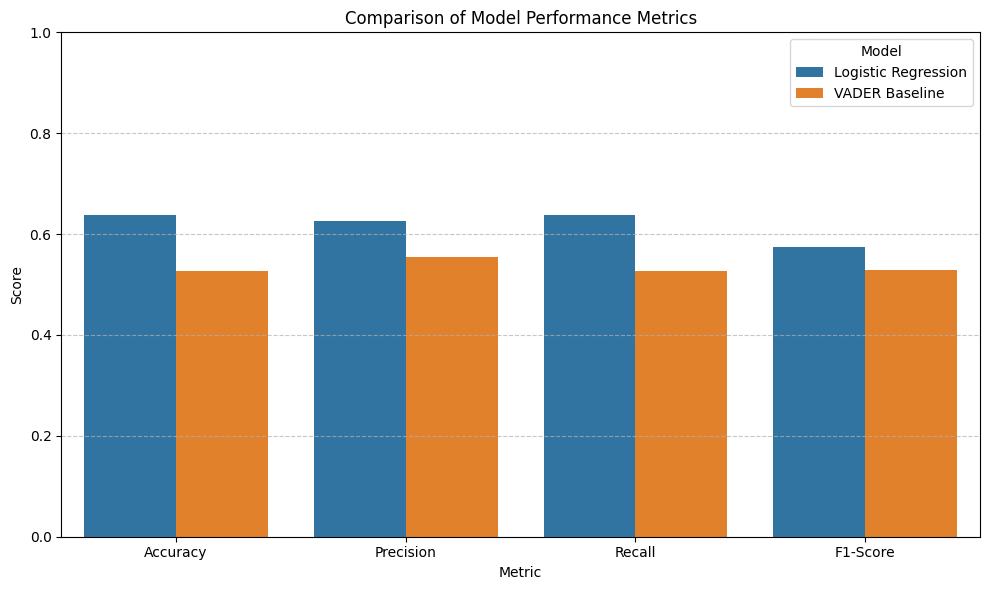

In [38]:
metrics_df_melted = metrics_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df_melted)
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are typically between 0 and 1
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()